In [1]:
!pip install segmentation-models

In [68]:
import os
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
import cv2
from keras.layers import Input, Conv2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
#from google.colab import drive
from keras.layers import Input, Conv2D, Reshape,BatchNormalization
import tensorflow as tf

In [69]:
os.system("gdalinfo")

1

In [70]:
os.environ["CUDA_VISIBLE_DEVICES"] = '/device:GPU:0'

In [71]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [72]:
#drive.mount('/content/drive')

# TIF 2

In [73]:
dataset1=gdal.Open('Clip_20180903.tif',gdal.GA_ReadOnly)

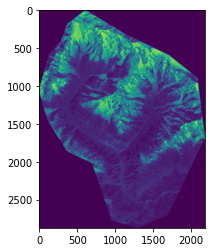

In [74]:
band = dataset1.GetRasterBand(2)
arr = band.ReadAsArray()
plt.imshow(arr)

In [75]:
bandList2=[]
for i in range (1,12):
    band = dataset1.GetRasterBand(i)
    arr = band.ReadAsArray()
    row=arr.shape[0]-(int(arr.shape[0]/256)*256)
    col=arr.shape[1]-(int(arr.shape[1]/256)*256)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    arr=x
    bandList2.append(arr)

In [76]:
np.unique(bandList2[0]).shape

(12844,)

In [77]:
arr.shape

(2816, 2048)

In [78]:
multiDimArray=np.zeros((arr.shape[0],arr.shape[1],16))
for i in range (1,12):
    band = dataset1.GetRasterBand(i)
    arr = band.ReadAsArray()
    row=arr.shape[0]-(int(arr.shape[0]/256)*256)
    col=arr.shape[1]-(int(arr.shape[1]/256)*256)
    l=list(range(arr.shape[0]-row,arr.shape[0]))
    x=np.delete(arr,l,0)
    l=list(range(arr.shape[1]-col,arr.shape[1]))
    x=np.delete(x,l,1)
    x = ((x - x.min()) * (1/(x.max() - x.min()) * 255)).astype('uint8')
    arr=x
    multiDimArray[:,:,i-1]=arr

In [79]:
np.max(multiDimArray)

255.0

## Ground Truth images 

In [80]:
oneBandArray=multiDimArray[:,:,0]

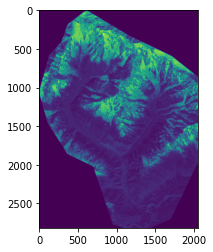

In [81]:
plt.imshow(oneBandArray)

In [82]:
np.unique(oneBandArray)

array([  0.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
       118., 119., 120., 121., 122., 123., 124., 125., 126., 127., 128.,
       129., 130., 131., 132., 133., 134., 135., 136., 137., 138., 139.,
       140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 15

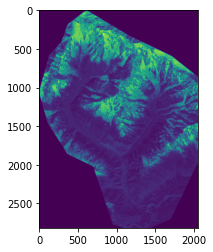

In [83]:
oneBandArray *= 255.0/oneBandArray.max() 
plt.imshow(oneBandArray)

In [84]:
iceRange=60
debriRange=0

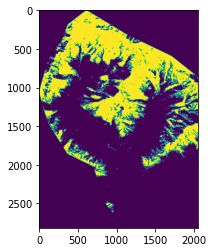

In [85]:
labelImg0=(oneBandArray>55).astype(int)
labelImg1=(oneBandArray>0)
labelImg11=(oneBandArray<=55)
labelImg1=(labelImg1*labelImg11).astype(int)
labelImg2=(oneBandArray==0).astype(int)
#labelImg=np.where(oneBandArray>55,2,oneBandArray)
#labelImg=np.where((oneBandArray>0) & (oneBandArray<=55) ,1,labelImg)
#labelImg=np.where(oneBandArray>0,1,oneBandArray)
#np.unique(labelImg)
plt.imshow(labelImg0)

In [86]:
labelImg1.shape

(2816, 2048)

In [87]:
#window_name = "image"
#cv2.imshow(window_name, labelImg1)
#cv2.setWindowProperty(window_name, cv2.WND_PROP_TOPMOST, 1)
#cv2.waitKey(0)

In [88]:
np.unique(labelImg1)


array([0, 1])

In [89]:
multiDimArray[:,:,13]=labelImg0
multiDimArray[:,:,14]=labelImg1
multiDimArray[:,:,15]=labelImg2

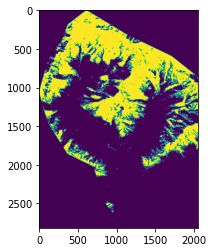

In [90]:
plt.imshow(multiDimArray[:,:,13])

## Patches

In [91]:
from sklearn.feature_extraction import image
import cv2

In [92]:
multiDimArray.shape

(2816, 2048, 16)

In [93]:
X=multiDimArray

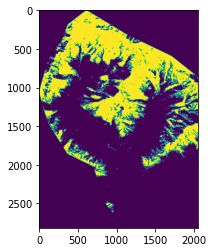

In [94]:
plt.imshow(X[:,:,13])

In [95]:
patchH=32
patchW=32
patches=image.extract_patches_2d(X,(patchH,patchW), max_patches=7000)

In [96]:
X=0

In [97]:
patches.shape

(7000, 32, 32, 16)

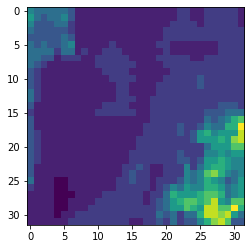

In [98]:
plt.imshow(patches[0][:,:,0])

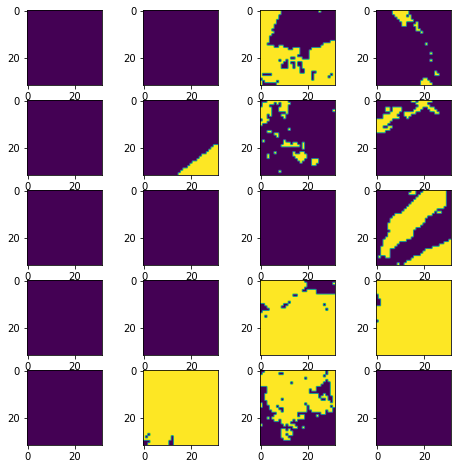

In [99]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = patches[i-1][:,:,13]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Train and test data

In [100]:
X=patches
print(X.shape)
y=patches[:,:,:,13:16]
print(y.shape)
X=X[:,:,:,0:12]
X.shape

(7000, 32, 32, 16)
(7000, 32, 32, 3)


(7000, 32, 32, 12)

In [101]:
patches=0

In [102]:
xTrain,xTest,yTrain,yTest=train_test_split(X,y, test_size=0.33, random_state=42)

In [103]:
X=0
y=0

## Model

In [104]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [105]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# preprocess input
xTrain = preprocess_input(xTrain)
xTest = preprocess_input(xTest)

# define model
base_model  = Unet(BACKBONE, encoder_weights='imagenet')

In [106]:
N=xTrain.shape[-1]
inp = Input(shape=(xTrain.shape[1], xTrain.shape[2], N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
x1 = Conv2D(10, kernel_size =3,padding = "same", activation="relu")(out)
x1 =BatchNormalization()(x1)
x2= Conv2D(10, kernel_size=3,padding = "same", activation="relu")(x1)
x2 =BatchNormalization()(x2)

x3 = Conv2D(10, kernel_size=3,padding = "same", activation="relu")(x2)
x3 =BatchNormalization()(x3)

x4 = Conv2D(3,1, activation="softmax")(x3)


model = Model(inp, x4, name=base_model.name)


In [107]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 12)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 3)         39        
                                                                 
 model_3 (Functional)        (None, None, None, 1)     24456154  
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 10)        100       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 10)       40        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 10)        910       
                                                           

In [109]:
EPOCHS=10
BATCHSIZE=32
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="/device:GPU:0" 

In [110]:
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
hist=model.fit(
    x=xTrain,
    y=yTrain,
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    validation_data=(xTest, yTest),
)

Epoch 1/10
147/147 [==============================] - 181s 1s/step - loss: 0.5385 - iou_score: 0.7571 - val_loss: 1.1657 - val_iou_score: 0.3731
Epoch 2/10
147/147 [==============================] - 178s 1s/step - loss: 0.2556 - iou_score: 0.8982 - val_loss: 1.4645 - val_iou_score: 0.3144
Epoch 3/10
147/147 [==============================] - 176s 1s/step - loss: 0.1936 - iou_score: 0.9203 - val_loss: 1.3716 - val_iou_score: 0.4912
Epoch 4/10
147/147 [==============================] - 175s 1s/step - loss: 0.1468 - iou_score: 0.9363 - val_loss: 0.8375 - val_iou_score: 0.6431
Epoch 5/10
147/147 [==============================] - 174s 1s/step - loss: 0.1315 - iou_score: 0.9415 - val_loss: 0.0860 - val_iou_score: 0.9588
Epoch 6/10
147/147 [==============================] - 174s 1s/step - loss: 0.1191 - iou_score: 0.9452 - val_loss: 0.0882 - val_iou_score: 0.9582
Epoch 7/10
147/147 [==============================] - 174s 1s/step - loss: 0.0957 - iou_score: 0.9548 - val_loss: 0.0713 - val_iou

In [112]:
def plotHist():
    plt.plot(hist.history['iou_score'])
    plt.plot(hist.history['val_iou_score'])
    plt.title("iou_score deep model for LandDebriIce")
    plt.xlabel('ephocs')
    plt.ylabel('intersection over union ')
    plt.legend(['train','validation'])
    plt.show()

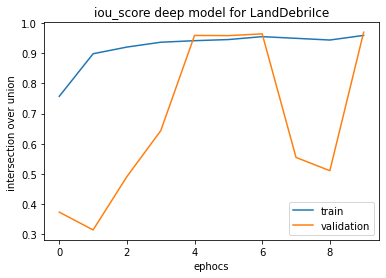

In [113]:
plotHist()

In [114]:
yPred=model.predict(xTest)

In [115]:
yPred.shape

(2310, 32, 32, 3)

In [116]:
for i in range (yPred.shape[0]):
    for j in range (yPred.shape[1]):
        for k in range (yPred.shape[2]):
                maxProb=np.argmax(yPred[i][j,k,:])
                yPred[i][j,k,:]=0
                if maxProb==0:
                    yPred[i][j,k,maxProb]=255
                elif maxProb==1:
                    yPred[i][j,k,maxProb]=127
                elif maxProb==2:
                    yPred[i][j,k,maxProb]=0


In [117]:
np.unique(yPred)

array([  0., 127., 255.], dtype=float32)

In [118]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [119]:
multiDimArray.shape

(2816, 2048, 16)

In [120]:
x=blockshaped(multiDimArray[:,:,0], nrows=patchH, ncols=patchW)
x.shape

(5632, 32, 32)

In [121]:
patchX=np.zeros((x.shape[0],x.shape[1],x.shape[2],12))
for i in range (multiDimArray.shape[2]-4):
    patchX[:,:,:,i]=blockshaped(multiDimArray[:,:,i], nrows=patchH, ncols=patchW)

In [122]:
np.unique(patchX)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

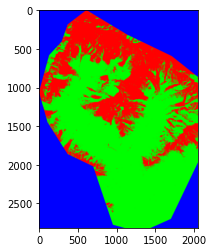

In [137]:
plt.imshow(multiDimArray[:,:,13:16])

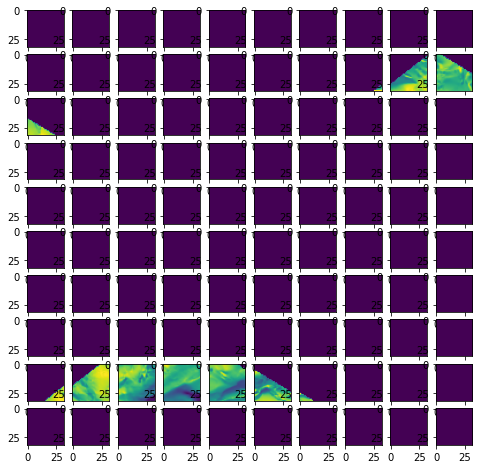

In [124]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = patchX[i-1][:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [125]:
yPred=model.predict(patchX)

In [126]:
for i in range (yPred.shape[0]):
    for j in range (yPred.shape[1]):
        for k in range (yPred.shape[2]):
            maxProb=np.argmax(yPred[i][j,k,:])
            yPred[i][j,k,:]=0
            if maxProb==0:
                yPred[i][j,k,maxProb]=255
            elif maxProb==1:
                yPred[i][j,k,maxProb]=127
            elif maxProb==2:
                yPred[i][j,k,maxProb]=0

In [127]:
np.unique(yPred)

array([  0., 127., 255.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

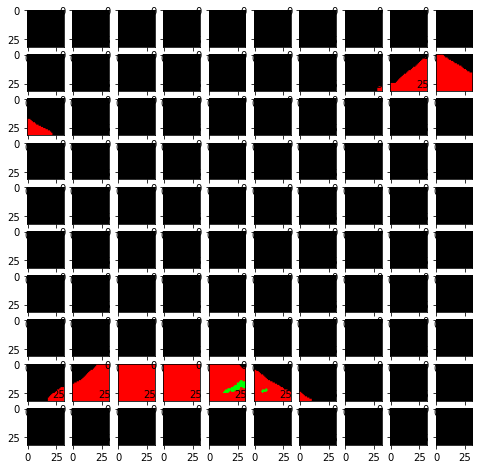

In [128]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = yPred[i-1][:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [129]:
yPred.shape

(5632, 32, 32, 3)

In [130]:
approxImg=np.zeros((multiDimArray.shape[0],multiDimArray.shape[1],3))

In [131]:
rows=int(multiDimArray.shape[0]/yPred.shape[1])
cols=int(multiDimArray.shape[1]/yPred.shape[1])

In [132]:
counter=0
advancement=yPred.shape[1]
for i in range (rows):
    for j in range (cols):

        approxImg[i*advancement:i*advancement+advancement,j*advancement:j*advancement+advancement,:]=yPred[counter]
        counter=counter+1    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


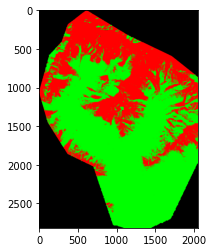

In [133]:
plt.imshow(approxImg)

In [66]:
cols/yPred.shape[1]

2.0

In [67]:
rows/yPred.shape[1]

2.75

In [32]:
tf.test.is_built_with_cuda()

True

In [33]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)


False

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']
